In [10]:
import tempfile
import math
import os
from subprocess import call
import matplotlib.pyplot as plt
from f90nml import *
from array import *
import numpy as np
import pandas as pd 
import seaborn as sns; sns.set_style("darkgrid")
from statistics import *
import shutil
import pdb
import sys
import matplotlib as mpl
import time
from numpy import mean
from numpy import std
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import linregress
from datetime import datetime
from IPython.display import clear_output


#read in printFolder, makeDefNameList, newFolder, deleteFolder, readOutput from coreFunctions.py
from coreFunctions import *

#read in plotting functionality from plottingFunctions.py
from plottingFunctions import *

call("rm -rf tmp*",shell=True)

dfModel = []#will contain output from our model

## Run Model


0.25% Completion   (0.934 AU)
 Runtime: 0.07 minutes have passed
 Runtime: 0.00 hours have passed 
Approximately 27.92 minutes until completion (0.47 hours) 



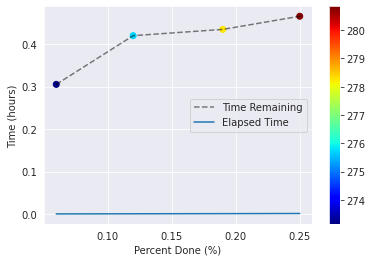

KeyboardInterrupt: 

In [23]:
start = time.time()
nameList = makeDefNamelist() #make namelist
#-------------------------------------Boolean Inputs--------------------------------------------------
plot=False;#make the fancy plots?
save=False#save the plots
coupled=True; #if this is False, program quits once EBM reaches equilibrium
analyze = True; #whether or not to analyze the population parts of model
lverbose=False; #controls terminal output, used for debugging
showInputs = False; #prints the namelist before running the program
#-------------------------------------Other Important Inputs-------------------------------------------------# maxPopList = [10000,40000,70000,100000] #specify all maxpops to use
exp =0
runTime=4000                          #Change runtime           (years)
#----------------------------------Set NameList Values to Specified Inputs---------------------
name="driver.exe"
verbose=False
carryCap=10000
deathPower = 2.00
dTemp = 2.5
#------------------------------------Run the Model----------------------------------------------------
n = 40
nameList['ebm']['lverbose'] = verbose
distanceList = [] #x
tempList = [] #y
dTdPList = []
dimVarList = []
pco2List = []
popDeathList = [] #amount of people dead within 2 generations of the peak
declineTime = [] #time for population to decline by 10% of its peak (any numbers over 500 are approximations)
anthroPopList = [] #anthrprogenic population
tempErrorList = [] #gives the absolute value of the difference between the goal equilibrium temp and that achieved by the returned value of pco2
peakPopList  = [] #max population reached
carryCapList = []
distances = np.linspace(0.934, 1.147, n)
goalEqTemps = np.linspace(273.15,373.15, n)
nameList['ebm']['dPower'] = deathPower
nameList['ebm']['dtemp'] = dTemp

numRuns = len(distances)*len(goalEqTemps)
counter = 0
timeLeftList = []
percentDoneList = []
timeList = []

for dist in distances:
    print("\n", "Distance: ", dist, " AU")
    for temp in goalEqTemps:
        carryCapList.append(carryCap/1000)
        distanceList.append(dist)
        tempList.append(temp)
        goalPco2, errorOnTemp = pco2Finder(temp, nameList, [dist], [carryCap], lverbose=verbose, driver=name)#False = suppress output
        eq = False
        tempErrorList.append(errorOnTemp)
        if np.isnan(goalPco2): popDeathList.append(np.nan)
        else:
            nameList['ebm']['pco20'] = goalPco2*10**-6
            dfModel,dfData,eq, eqTemp, eqTime, popDeath = runModel(nameList, True, 3000, False, False, False,name,[carryCap],[dist],showInputs, analyzeVerbose=False, experiment=0, scaleInitPop=True)
            popDeathList.append(popDeath[0])
        pco2List.append(goalPco2)
        goaldTdP = dTdPFinder(goalPco2, dist, nameList, [carryCap], driver=name)
        dTdPList.append(goaldTdP)
        anthroPop = (nameList['ebm']['rBirth0']*nameList['ebm']['dtemp'])/(nameList['ebm']['rco2']*goaldTdP)
        anthroPopList.append(anthroPop/1000)
        if eq:
            popStats = analyzeRun(dfModel,nameList, anthroPop, verbose)
            #print(f"Distance: {dist:.1f}, Temp: {temp:.1f}, MaxPop: {popStats['maxPop']:.0f}")
            peakPopList.append(popStats['maxPop'])
            declineTime.append(popStats['tDecline'])
        else:
            declineTime.append(np.nan)
            peakPopList.append(np.nan)
#        print(f"dTdP: {goaldTdP:.3e}")
        if not np.isnan(goalPco2): dimVar=(carryCap*nameList['ebm']['rco2']*goaldTdP)/(nameList['ebm']['rBirth0']*nameList['ebm']['dtemp'])
        if np.isnan(goalPco2): dimVar = np.nan
        dimVarList.append(dimVar)
        counter += 1
        end = time.time()
        clear_output()
        percentDone = round((counter/numRuns)*100,2)
        print("\n"+str(percentDone) + "% Completion   ("+str(dist)+" AU)" )
        timeSeconds = end-start
        timeMinutes = timeSeconds/60
        timeHours = timeMinutes/60
        print(f" Runtime: {timeMinutes:.2f} minutes have passed")
        print(f" Runtime: {timeHours:.2f} hours have passed ")
        if percentDone > 0:
            timeLeftMin = timeRemaining(percentDone, timeMinutes)
            timeLeftHours = timeLeftMin/60
            print(f"Approximately {timeLeftMin:.2f} minutes until completion ({timeLeftHours:.2f} hours) \n")
            timeLeftList.append(timeLeftMin)
            timeList.append(timeMinutes)
            percentDoneList.append(percentDone)
            timeLeftListH = [i/60 for i in timeLeftList]
            timeListH = [i/60 for i in timeList]
            fig, ax = plt.subplots()
            plt.plot(percentDoneList, timeLeftListH, label="Time Remaining", c='black',ls='--', alpha=0.5)
            a = plt.scatter(percentDoneList, timeLeftListH, c=tempList, cmap=plt.cm.jet)
            cbar = fig.colorbar(a, ax=ax)
            plt.clim(min(tempList), max(tempList))
            plt.plot(percentDoneList, timeListH, label="Elapsed Time")
            plt.xlabel("Percent Done (%)")
            plt.ylabel("Time (hours)")
            plt.legend()
            plt.show()
#        print(f"Dimensionless Variable: {dimVar}","\n")
#-------------------------------------------------------
df = pd.DataFrame()
df["dist"] = distanceList #x
df["temp"] = tempList     #y
df["dTdP"] = dTdPList
df["pco20"] = pco2List
df["gamma"] = dimVarList
df["popDeath"] = popDeathList
df["declineTime"] = declineTime
df["peakPopList"] = peakPopList
df["carryCapList"] = carryCapList
df["anthroPopList"] = anthroPopList
df["tempError"] = tempErrorList
df["timeLeftMin"] = timeLeftList
df["percentDone"] = percentDoneList
df["timeElapsedMinutes"] = timeList
#---------------------------------------------------------
df["logGamma"] = np.log10(df.gamma)
df["logdTdP"] = np.log10(df.dTdP)
df["logpco20"] = np.log10(df.pco20)
df["logpopDeath"] = np.log10(df.popDeath)
df["logdeclineTime"] = np.log10(df.declineTime)
df["logAnthroPop"] = np.log10(df.anthroPopList)
#----------------------------------------------------------
now = datetime.now() # current date and time
month = now.strftime("%m")
day = now.strftime("%d")
dateToday = f"{month}_{day}"
#df.to_csv("dataSweep_" + dateToday +"_NMax10B_dT"+str(int(dTemp))+"_dPower"+str(int(deathPower))+".csv")
#--------------------------------------------------------
def tCollapse(gamma):
    if(np.isnan(gamma)): return np.nan
    else:
        return max(1, 1/gamma)
df['normCollapseTime'] = df['gamma'].apply(tCollapse)
A0 = 0.04
df['logCollapseTime'] = np.log10(df['normCollapseTime']/A0)
df['logAnthroPopPpl'] = np.log10(df['anthroPopList']*10**9)
#-----------------------------------------------------
end = time.time()
timeSeconds = end-start
timeMinutes = (timeSeconds)/60
timeHours = timeMinutes/60
print(f"Runtime: {timeMinutes:.2f} minutes")
print(f"Runtime: {timeHours:.2f} hours")
print(f"Average Time to advance 1%: {timeSeconds/100} s")
call("echo End of Python Notebook Reached", shell=True);

In [5]:
help(plt.plot)

Help on function plot in module matplotlib.pyplot:

plot(*args, scalex=True, scaley=True, data=None, **kwargs)
    Plot y versus x as lines and/or markers.
    
    Call signatures::
    
        plot([x], y, [fmt], *, data=None, **kwargs)
        plot([x], y, [fmt], [x2], y2, [fmt2], ..., **kwargs)
    
    The coordinates of the points or line nodes are given by *x*, *y*.
    
    The optional parameter *fmt* is a convenient way for defining basic
    formatting like color, marker and linestyle. It's a shortcut string
    notation described in the *Notes* section below.
    
    >>> plot(x, y)        # plot x and y using default line style and color
    >>> plot(x, y, 'bo')  # plot x and y using blue circle markers
    >>> plot(y)           # plot y using x as index array 0..N-1
    >>> plot(y, 'r+')     # ditto, but with red plusses
    
    You can use `.Line2D` properties as keyword arguments for more
    control on the appearance. Line properties and *fmt* can be mixed.
    The f

## Plotting

In [ ]:
carryCap=10000
deathPower=2
dTemp=5
name='dataSweep_04_10_NMax10B_dT5_dPower2';
df = pd.read_csv(str(name)+'.csv')
filter = df["logpco20"] <= 5.1  # making boolean series 
for i in np.arange(3,18,1):
    df[df.columns[i]].where(filter, inplace = True) #filter data

df7 = df[["dist", "temp", "logAnthroPopPpl"]]
df7 = df7.pivot("dist", "temp", "logAnthroPopPpl")
x5 = np.asarray(df7.index)
y5 = np.asarray(df7.columns)
xx5, yy5 = np.meshgrid(x5,y5)
zz5 = np.zeros_like(xx5)
for i in range(zz5.shape[0]):
    for j in range(zz5.shape[1]):
        zz5[j,i] = df7.iloc[i,j]

df6 = df[["dist", "temp", "logCollapseTime"]]
df6 = df6.pivot("dist", "temp", "logCollapseTime")
x4 = np.asarray(df6.index)
y4 = np.asarray(df6.columns)
xx4, yy4 = np.meshgrid(x4,y4)
zz4 = np.zeros_like(xx4)
for i in range(zz4.shape[0]):
    for j in range(zz4.shape[1]):
        zz4[j,i] = df6.iloc[i,j]


df5 = df[["dist", "temp", "logdeclineTime"]]
df5 = df5.pivot("dist", "temp", "logdeclineTime")
x3 = np.asarray(df5.index)
y3 = np.asarray(df5.columns)
xx3, yy3 = np.meshgrid(x3,y3)
zz3 = np.zeros_like(xx3)
for i in range(zz3.shape[0]):
    for j in range(zz3.shape[1]):
        zz3[j,i] = df5.iloc[i,j]
    
# peakPopRatioList = np.log10((df["peakPopList"]/df["carryCapList"])
# df['peakPopRatio'] = peakPopRatioList
df['peakPopPercent'] = (df['peakPopList']/df['carryCapList'])*100
df4 = df[["dist", "temp", "peakPopPercent"]]
df4 = df4.pivot("dist", "temp", "peakPopPercent")
x2 = np.asarray(df4.index)
y2 = np.asarray(df4.columns)
xx2, yy2 = np.meshgrid(x2,y2)
zz2 = np.zeros_like(xx2)
for i in range(zz2.shape[0]):
    for j in range(zz2.shape[1]):
        zz2[j,i] = df4.iloc[i,j]
        
        
df2 = df[["dist", "temp", "logpco20"]]
df2 = df2.pivot("dist", "temp", "logpco20")
x = np.asarray(df2.index)
y = np.asarray(df2.columns)
xx, yy = np.meshgrid(x,y)
zz = np.zeros_like(xx)
for i in range(zz.shape[0]):
    for j in range(zz.shape[1]):
        zz[j, i] = df2.iloc[i,j]
            
df3 = df[["dist", "temp", "logGamma"]]
df3 = df3.pivot("dist", "temp", "logGamma")
x1 = np.asarray(df3.index)
y1 = np.asarray(df3.columns)
xx1, yy1 = np.meshgrid(x1,y1)
zz1 = np.zeros_like(xx1)
for i in range(zz1.shape[0]):
    for j in range(zz1.shape[1]):
        zz1[j,i] = df3.iloc[i,j]

fs = 15
fig, axes = plt.subplots(figsize=(25,30), nrows=3, ncols=2)
#-----------------------------------log-Pco20---------------------------------------------------------
contourLines = np.asarray([0,1,2,3,4, 5])
ax = axes[0,0]
colorMap = "plasma_r"
cmm = plt.get_cmap(colorMap)
cmm.set_bad(color='grey')
cs1 = ax.pcolormesh(yy, xx, zz, alpha=0.9,cmap=cmm)
#cs2 = ax.contour(yy, xx, zz, cmap=colorMap, levels=contourLines)
cs2 = ax.contour(yy, xx, zz, cmap=cmm, levels=contourLines)
#ax.clabel(cs2, inline=True, fontsize=14, colors="Black", fmt=r"$10^{%d}$") #set contour labels
ax.clabel(cs2, inline=True, fontsize=fs, colors="Black", fmt=r"$10^{%1.1f}\ ppm$") #set contour labels
ax.set(xlabel=r'$Temperature\ (K)$', ylabel=r'$Distance\ (AU)$', title=r"Distance  (AU)  vs  Temperature  (K)  vs  $log\ pCO_{2}\ (ppm)$") #set axis labels;
ax.set_xlim(273.15,360)
cbar = fig.colorbar(cs1, ax=ax);
cbar.set_label(r"$log\ pCO_{2}\ (ppm)$")

#-----------------------------------log-Gamma---------------------------------------------------------
#contourLines = np.asarray([-4,-3,-2,-1,0])
ax = axes[0,1]
colorMap = "viridis"
cmm = plt.get_cmap(colorMap)
cmm.set_bad(color='grey')
cs1 = ax.pcolormesh(yy1, xx1, zz1, alpha=0.9,cmap=cmm)
#cs2 = ax.contour(yy1, xx1, zz1, cmap=colorMap, levels=contourLines)
cs2 = ax.contour(yy1, xx1, zz1, cmap=colorMap)
#ax.clabel(cs2, inline=True, fontsize=14, colors="Black", fmt=r"$10^{%d}$") #set contour labels
ax.clabel(cs2, inline=True, fontsize=fs, colors="Black", fmt=r"$10^{%1.1f}$") #set contour labels
ax.set(xlabel=r'$Temperature\ (K)$', ylabel=r'$Distance\ (AU)$', title=r"Distance  (AU)  vs  Temperature  (K)  vs  $log\ Gamma\ (log\ \gamma)$") #set axis labels;
ax.set_xlim(273.15,360)
cbar = fig.colorbar(cs1, ax=ax);
cbar.set_label(r"$log\ Gamma\ (log\ \gamma)$")

# # #-----------------------------------log-Gamma-pCo2------------------------------------------------------
# # #contourLines = np.asarray([-4,-3,-2,-1,0])
# contourLines = np.asarray([0,1,2,3,4, 4.5])
# ax = axes[2,1]
# colorMap = "viridis"
# cmm = plt.get_cmap(colorMap)
# cmm.set_bad(color='grey')
# cs1 = ax.pcolormesh(yy1, xx1, zz1, alpha=0.9,cmap=cmm)
# #cs2 = ax.contour(yy1, xx1, zz1, cmap=colorMap, levels=contourLines)
# cs2 = ax.contour(yy, xx, zz, cmap="plasma_r", levels=contourLines)
# #ax.clabel(cs2, inline=True, fontsize=fs, colors="Black", fmt=r"$10^{%d}$") #set contour labels
# ax.clabel(cs2, inline=True, fontsize=fs, colors="Black", fmt=r"$10^{%1.1f}\ ppm$") #set contour labels
# ax.set(xlabel=r'$Temperature\ (K)$', ylabel=r'$Distance\ (AU)$', title=r"Distance  (AU)  vs  Temperature  (K)  vs  $log\ Gamma$  (Contoured by $pCO2$)") #set axis labels;
# ax.set_xlim(273.15,360)
# cbar = fig.colorbar(cs1, ax=ax);
# cbar.set_label(r"$log\ Gamma\ (log\ \gamma)$")

# #-----------------------------------AnthroPop------------------------------------------------------
# #contourLines = np.asarray([-4,-3,-2,-1,0])
#contourLines = np.asarray([0,1,2,3,4, 4.5])
ax = axes[2,1]
colorMap = "jet_r"
cmm = plt.get_cmap(colorMap)
cmm.set_bad(color='grey')
cs1 = ax.pcolormesh(yy5, xx5, zz5, alpha=0.9,cmap=cmm)
#cs2 = ax.contour(yy1, xx1, zz1, cmap=colorMap, levels=contourLines)
cs2 = ax.contour(yy5, xx5, zz5, cmap=cmm)
#ax.clabel(cs2, inline=True, fontsize=14, colors="Black", fmt=r"$10^{%d}$") #set contour labels
ax.clabel(cs2, inline=True, fontsize=fs, colors="Black", fmt =r"$10^{%1.1f}\ ppl$") #set contour labels
ax.set(xlabel=r'$Temperature\ (K)$', ylabel=r'$Distance\ (AU)$', title=r"Distance  (AU)  vs  Temperature  (K)  vs  Anthropogenic Population ($N_{A}$)") #set axis labels;
ax.set_xlim(273.15,360)
cbar = fig.colorbar(cs1, ax=ax);
cbar.set_label(r"$logN_{A}\ ppl$")

# #-----------------------------------tCollapse------------------------------------------------------
# #contourLines = np.asarray([-4,-3,-2,-1,0])
ax = axes[1,1]
colorMap = "jet_r"
cmm = plt.get_cmap(colorMap)
cmm.set_bad(color='grey')
cs1 = ax.pcolormesh(yy4, xx4, zz4, alpha=0.9,cmap=cmm)
#cs2 = ax.contour(yy1, xx1, zz1, cmap=colorMap, levels=contourLines)
cs2 = ax.contour(yy4, xx4, zz4, cmap=cmm)
#ax.clabel(cs2, inline=True, fontsize=14, colors="Black", fmt=r"$10^{%d}$") #set contour labels
ax.clabel(cs2, inline=True, fontsize=fs, colors="Black",  fmt=r"$10^{%1.1f}\ yr$") #set contour labels
ax.set(xlabel=r'$Temperature\ (K)$', ylabel=r'$Distance\ (AU)$', title=r"Distance  (AU)  vs  Temperature  (K)  vs  $log\ t_{collapse}\ (yrs)$") #set axis labels;
ax.set_xlim(273.15,360)
cbar = fig.colorbar(cs1, ax=ax);
cbar.set_label(r"$log\ t_{collapse}\ (yrs)$")
#-----------------------------------Peak Population Percent------------------------------------------------------
contourLines = np.asarray([10, 70, 90, 99,99.9])
ax = axes[2,0]
colorMap = "jet_r"
cmm = plt.get_cmap(colorMap)
cmm.set_bad(color='grey')
cs7 = ax.pcolormesh(yy2, xx2, zz2, alpha=0.8,cmap=cmm)
cs8 = ax.contour(yy2, xx2, zz2, cmap=cmm, levels=contourLines)
ax.clabel(cs8, inline=True, fontsize=fs, colors="Black", fmt=r"%1.0f%%") #set contour labels
#ax.clabel(cs8, inline=True, fontsize=14, colors="Black", fmt=r"$10^{%1.1f}\ ppm$) #set contour labels
#ax.clabel(cs2, inline=True, fontsize=14, colors="Black", fmt=r"$10^{%1d}\$") #set contour labels
ax.set(xlabel=r'$Temperature\ (K)$', ylabel=r'$Distance\ (AU)$', title=r"Distance  (AU) vs  Temperature  (K)  vs  Percent of Carrying Capacity Achieved") #set axis labels;
ax.set_xlim(273.15,360)
cbar = fig.colorbar(cs7, ax=ax);
cbar.set_label("%")
#-----------------------------------log-tDecline------------------------------------------------------
contourLines = np.asarray([0,1.25,1.75,2.25])
ax = axes[1,0]
colorMap = "jet_r"
cmm = plt.get_cmap(colorMap)
cmm.set_bad(color='grey')
cs5 = ax.pcolormesh(yy3, xx3, zz3, alpha=0.9,cmap=cmm)
cs6 = ax.contour(yy3, xx3, zz3, cmap=cmm)
ax.clabel(cs6,  fontsize=fs, colors="Black", fmt=r"$10^{%1.2f}\ yr$") #set contour labels
#ax.clabel(cs2, inline=True, fontsize=14, colors="Black", fmt=r"$10^{%1d}\$") #set contour labels
ax.set(xlabel=r'$Temperature\ (K)$', ylabel=r'$Distance\ (AU)$', title=r"Distance  (AU) vs  Temperature  (K)  vs  $log\ t_{decline}\ (yrs)$") #set axis labels;
ax.set_xlim(273.15,360)
cbar = fig.colorbar(cs5, ax=ax);
cbar.set_label(r"$log\ t_{decline}\ (yrs)$")
plt.suptitle(fr"Carrying Capacity = {carryCap/1000:.0f} Billion,    $\Delta$T = {dTemp:.0f},     Exponent = {deathPower:.0f}", y=.905,fontsize=25)
#plt.savefig("EBMPlots_April2020/"+name+".png")
plt.show()

In [ ]:
df_100 = pd.read_csv('dataSweep_03_25_NMax_100_billion.csv')
df_10 = pd.read_csv('dataSweep_03_27_NMax_10_billion.csv')
df_10['peakPopPercent'] = (df_10['peakPopList']/df_10['carryCapList'])*100
df_100['peakPopPercent'] = (df_100['peakPopList']/df_100['carryCapList'])*100
df_10['logAnthroPopPpl'] = np.log10(df_10['anthroPopList']*10**9)
df_100['logAnthroPopPpl'] = np.log10(df_100['anthroPopList']*10**9)
def tCollapse(gamma):
    if(np.isnan(gamma)): return np.nan
    else:
        return max(1, 1/gamma)
A0 = 0.04
df_10['normCollapseTime'] = df_10['gamma'].apply(tCollapse)
df_10['logCollapseTime'] = np.log10(df_10['normCollapseTime']/A0)
df_100['normCollapseTime'] = df_100['gamma'].apply(tCollapse)
df_100['logCollapseTime'] = np.log10(df_100['normCollapseTime']/A0)

dfNew100 = df_100[['logpco20','logGamma','peakPopPercent','logdeclineTime','logCollapseTime','logAnthroPopPpl','carryCapList']]
dfNew10 = df_10[['logpco20','logGamma','peakPopPercent','logdeclineTime','logCollapseTime','logAnthroPopPpl','carryCapList']]
dfNew = pd.concat([dfNew10, dfNew100])

# g = sns.PairGrid(dfNew, hue="carryCapList")
# g.map_offdiag(plt.scatter, s=10)
# g.map_diag(plt.hist)
# g.add_legend()
# plt.show()

#sns.pairplot(dfNew, hue='carryCapList')
df_10.head()

Plotting With Different Exponent Values

In [ ]:
max(np.asarray(dfE1.popDeath[~np.isnan(dfE1.popDeath)]))

In [ ]:
dfE1 = pd.read_csv("dataSweep_04_09_NMax10B_dT5_dPower1.csv")
dfE2 = pd.read_csv("dataSweep_04_10_NMax10B_dT5_dPower2.csv")
dfE4 = pd.read_csv("dataSweep_04_06_NMax10B_dT5_dPower4.csv")
dfE8 = pd.read_csv("dataSweep_04_07_NMax10B_dT5_dPower8.csv")

name='logdeclineTime'
lDT1 = np.asarray(dfE1[name])
lDT2 = np.asarray(dfE2[name])
lDT4 = np.asarray(dfE4[name])
lDT8 = np.asarray(dfE8[name])

name='popDeath'
lPD1 = np.asarray(np.log10(dfE1[name]*10**6))
lPD2 = np.asarray(np.log10(dfE2[name]*10**6))
lPD4 = np.asarray(np.log10(dfE4[name]*10**6))
lPD8 = np.asarray(np.log10(dfE8[name]*10**6))

sns.set_style("darkgrid")
fig, axes = plt.subplots(figsize=(10,10), nrows=2, ncols=1)

ax = axes[0]
sns.kdeplot(lDT1, label="d = 1", shade=True, ax=ax);
sns.kdeplot(lDT2, label="d = 2", shade=True, ax=ax);
sns.kdeplot(lDT4, label="d = 4", shade=True, ax=ax);
sns.kdeplot(lDT8, label="d = 8", shade=True, ax=ax);
ax.legend(fontsize=20)
ax.set_xlabel(r"Log Decline Time  ($10^x\ yrs$)", fontsize=15)

ax = axes[1]
sns.kdeplot(lPD1, label="d = 1", shade=True, ax=ax);
sns.kdeplot(lPD2, label="d = 2", shade=True, ax=ax);
sns.kdeplot(lPD4, label="d = 4", shade=True, ax=ax);
sns.kdeplot(lPD8, label="d = 8", shade=True, ax=ax);
ax.legend(fontsize=20)
ax.set_xlabel(r"Log Pop Death  ($10^x\ million\ ppl$)", fontsize=15)

plt.suptitle(r"$\alpha_{death}=\alpha_{death,0}\left[1+\left(\frac{T-T_{eq}}{\Delta T}\right)^{d}\right]$",
         fontsize=25)
plt.tight_layout()
plt.subplots_adjust(top=0.91)
#plt.savefig("EBMPlots_April2020/power_histograms.png")
plt.show()


In [ ]:
import warnings
warnings.filterwarnings("ignore")
#-------------------------------Getting the Data-------------------------------------------------------
df_100 = pd.read_csv('dataSweep_03_25_NMax_100_billion.csv')
df_10 = pd.read_csv('dataSweep_03_27_NMax_10_billion.csv')
df_10['peakPopPercent'] = (df_10['peakPopList']/df_10['carryCapList'])*100
df_100['peakPopPercent'] = (df_100['peakPopList']/df_100['carryCapList'])*100
def tCollapse(gamma):
    if(np.isnan(gamma)): return np.nan
    else:
        return max(1, 1/gamma)
def addCollapse(df):
    df['normCollapseTime'] = df['gamma'].apply(tCollapse)
    A0 = 0.04
    df['logCollapseTime'] = np.log10(df['normCollapseTime']/A0)
    df['logAnthroPopPpl'] = np.log10(df['anthroPopList']*10**9)
    return df
df_10 = addCollapse(df_10)
df_100 = addCollapse(df_100)
# #--------------------------------Remove Values that have Toxic pCO2's-------------------------------------- 
# filter = df_10["logpco20"] <= 5.0  # making boolean series 
# for i in np.arange(3,18,1):
#     df_10[df_10.columns[i]].where(filter, inplace = True) #filter data
# filter = df_100["logpco20"] <= 5.0  # making boolean series 
# for i in np.arange(3,18,1):
#     df_100[df_100.columns[i]].where(filter, inplace = True) #filter data
#--------------------------------Specify Names--------------------------
#popDeath = number of people who died within 2 generations (50) years of the peak
#declineTime = time it took for population to decline by 10% of peak pop
#collapseTime = analytically calculated time for collapse (free fall time)
plotVars = ['logpco20', 'logGamma', 'logdeclineTime', 
                'logCollapseTime','logpopDeath', 'logAnthroPopPpl']
pTitles = [r"$log\ pCO_{2}\ (ppm)$", r"$log\ Gamma\ (log\ \gamma)$",
              r'Log $t_{decline}$ (yrs)', r"$log\ t_{collapse}\ (yrs)$",
              "log popDeath (ppl)", r"$log\ N_{A}\ (ppl)$"]
#--------------------------------------------------------------------
sns.set_style("darkgrid")
sns.set(font_scale = 2)
fig1 = plt.figure(figsize=(25,30)) #One 2D Kdeplots
fig2 = plt.figure(figsize=(25,30)) #Two 1D Kdeplots
for i in range(6):
    axInd = i+1
    #-------------------------------Choose Variable and Name----------------------------------------------------------------------   
    plotVar = plotVars[i]
    pTitle = pTitles[i]
    #--------------------------------Make new Dataframe-------------------------------
    n100 = df_100[plotVar]
    n10 = df_10[plotVar]
    dfCC = pd.DataFrame({'n100' : n100, 'n10' : n10}) #create new dataframe with both carrying capacities
    dfCC.dropna(inplace=True) #drop all null values
    #----------------One 2D kdeplot-------------------------------
    ax1 = fig1.add_subplot(3, 2, axInd)
    sns.kdeplot(dfCC.n10, dfCC.n100, cmap="jet", shade=True, ax=ax1, cbar=True)
    ax1.set_xlabel("Carrying Capacity: 10 Billion", fontsize=22)
    if(axInd % 2 != 0 ): ax1.set_ylabel("Carrying Capacity: 100 Billion", fontsize=22)
    if(axInd % 2 == 0 ): ax1.set_ylabel("")
    if(axInd > 4): ax1.set_xlabel("Carrying Capacity: 10 Billion", fontsize=22)
    if(axInd <= 4): ax1.set_xlabel("") 
    ax1.set_title(pTitle, fontsize=27)
    #----------------Two 1D kdeplot-------------------------------
    ax2 = fig2.add_subplot(3, 2, axInd)
    sns.kdeplot(dfCC.n10, shade=True, label="10 billion", ax=ax2);
    sns.kdeplot(dfCC.n100, shade=True, label="100 billion",linestyle="--", dashes=(5, 10),ax=ax2)
    if(axInd % 2 != 0 ): ax2.set_ylabel("Count", fontsize=22)
    if(axInd % 2 == 0 ): ax2.set_ylabel("")
    ax2.set_xlabel(pTitle, fontsize=22)
    ax2.set_title(pTitle + " for Different Carrying Capacities", fontsize=25)
    #ax2.set_title(pTitle, fontsize=27)
    #----------------Two 1D kdeplots-------------------------------  
# fig1.savefig("EBMPlots_March2020/Cool_Plots/2dhists.png");
fig1.savefig("EBMPlots_April2020/2dhists.png");
fig2.savefig("EBMPlots_April2020/1dhists.png");
plt.show()
# #----------------Big Plot------------------------
sns.set(context='notebook', font_scale = 1.5)
sns.set_style('ticks')
for i in range(6):
    axInd = i+1
    #-------------------------------Choose Variable and Name----------------------------------------------------------------------   
    plotVar = plotVars[i]
    pTitle = pTitles[i]
    #--------------------------------Make new Dataframe-------------------------------
    n100 = df_100[plotVar]
    n10 = df_10[plotVar]
    dfCC = pd.DataFrame({'n100' : n100, 'n10' : n10}) #create new dataframe with both carrying capacities
    dfCC.dropna(inplace=True) #drop all null values
    #---------------------------------------Plot-------------
    fig = plt.figure(figsize=(2,10))
    ax = sns.JointGrid(x="n10", y="n100",data=dfCC, space=0)
    ax = ax.plot_marginals(sns.distplot)
    ax = ax.plot_joint(sns.kdeplot)
    ax.set_axis_labels('Carrying Capacity: 10 Billion', 'Carrying Capacity: 100 Billion', fontsize=13)
    ax.fig.set_size_inches(7,6)
    plt.suptitle(pTitle,y=.9999, fontsize=15)
   # plt.subplots_adjust
    plt.savefig(f"EBMPlots_April2020/Cool_Plots/{plotVar}.png"); 
    plt.show();

In [ ]:
import warnings
warnings.filterwarnings("ignore")
#-------------------------------Getting the Data-------------------------------------------------------
df_100 = pd.read_csv('dataSweep_03_25_NMax_100_billion.csv')
df_10 = pd.read_csv('dataSweep_03_27_NMax_10_billion.csv')
df_10['peakPopPercent'] = (df_10['peakPopList']/df_10['carryCapList'])*100
df_100['peakPopPercent'] = (df_100['peakPopList']/df_100['carryCapList'])*100
def tCollapse(gamma):
    if(np.isnan(gamma)): return np.nan
    else:
        return max(1, 1/gamma)
def addCollapse(df):
    df['normCollapseTime'] = df['gamma'].apply(tCollapse)
    A0 = 0.04
    df['collapseTime'] = df['normCollapseTime']/A0
    df['logCollapseTime'] = np.log10(df['normCollapseTime']/A0)
    df['logAnthroPopPpl'] = np.log10(df['anthroPopList']*10**9)
    return df
df_10 = addCollapse(df_10)
df_100 = addCollapse(df_100)
# #---------------------------
lct10 = np.asarray(df_10.logCollapseTime)
ldt10 = np.asarray(df_10.logdeclineTime)
lct100 = np.asarray(df_100.logCollapseTime)
ldt100 = np.asarray(df_100.logdeclineTime)

data2DList = []
for c,d in zip(lct10,ldt10):
    list1D = []
    list1D.append(d)
    list1D.append(c)
    list1D.append(10)
    data2DList.append(list1D)
for c,d in zip(lct100,ldt100):
    list1D = []
    list1D.append(d)
    list1D.append(c)
    list1D.append(100)
    data2DList.append(list1D)
dfTime = pd.DataFrame(data2DList,columns=['logDeclineTime','logCollapseTime','carryingCapacity'])
dfTime.dropna(inplace=True)
dfTime.reset_index(inplace=True, drop=True)

#sns.jointplot(x='logDeclineTime', y='logCollapseTime', data=dfTime, s=2)
lDT = np.asarray(dfTime.logDeclineTime)
lCT = np.asarray(dfTime.logCollapseTime)
cc = np.asarray(dfTime.carryingCapacity)
cc10 = (cc == 10)
cc100 = ~ cc10
sns.set_style('darkgrid')
ax, fig = plt.subplots(figsize=(12,7))
dD = .075 * max(lDT)
dC = .075 * max(lCT)
plt.xlim(min(lDT) - dD, max(lDT) + dD)
#plt.title("Analytically Derived Collapse Time vs Numerically Derived Free Fall Time")
sns.kdeplot(lDT,shade=True, label='log Decline Time')
sns.kdeplot(lCT, shade=True, label='log Collapse Time')
plt.tight_layout()
plt.savefig("EBMPlots_April2020/kdeplotsLDT_LCT.png");

mean10 = np.mean(lDT[cc10])
mean100 = np.mean(lDT[cc100])
cc10Err = []
cc100Err = []
for i, j in zip(lDT[cc10], lDT[cc100]):
    cc10Err.append((i-mean10)**2)
    cc100Err.append((j-mean100)**2)

sns.set_style('darkgrid')
from matplotlib import cm
ax, fig = plt.subplots(figsize=(11,7))
sns.kdeplot(lDT, lCT,c='black', shade=False)
plt.scatter(lDT[cc100][:-1], lCT[cc100][:-1],c='red',alpha=.3, s=10,label="100b Carrying Cap")
plt.scatter(lDT[cc10], lCT[cc10],c="blue",alpha=.3, s=10, label="10b Carrying Cap")
plt.xlabel("log Decline Time (yrs)")
plt.ylabel("log Collapse Time (yrs)")
dD = .075 * max(lDT)
dC = .075 * max(lCT)
plt.xlim(min(lDT) - dD, max(lDT) + dD)
plt.ylim(min(lCT) - dC, max(lCT) + dC)
plt.legend()
#plt.title("Analytically Derived Collapse Time vs Numerically Derived Free Fall Time")
plt.tight_layout()
plt.savefig("EBMPlots_April2020/declinetime_vs_collapsetime.png")

# sns.kdeplot(lDT[cc100], lCT[cc100],
#             cmap="Reds", shade=False)

# dfTime2 = pd.DataFrame()
# dfTime2['lCT100'] = lCT[cc100][1:]
# dfTime2['lDT100'] = lDT[cc100][1:]
# dfTime2['lCT10'] = lCT[cc10]
# dfTime2['lDT10'] = lDT[cc10]
# #sns.jointplot(x='logDeclineTime',y='logCollapseTime',data = dfTime)
# sns.jointplot(x='logDeclineTime',y='logCollapseTime', kind='kde',data = dfTime)
# plt.show()

# g = sns.jointplot(x='logDeclineTime',y='logCollapseTime', data=dfTime, dropna=True,kind='kde',shade=False)
# g.plot_joint(plt.scatter, alpha=.2, c='black', s=2)
# plt.show()

# g.ax_joint.collections[0].set_alpha(0)
# g.set_axis_labels("$X$", "$Y$");
# sns.set_context("notebook")
# plt.scatter(lDT[cc10], lCT[cc10], label="Carrying Cap: 10B",s=1,alpha=.1)
# plt.scatter(lDT[cc100], lCT[cc100], label="Carrying Cap: 100B",c='r',s=1,alpha=.1)
# plt.legend(fontsize=15)
# plt.xlabel("Log Decline Time")
# plt.ylabel("Log Collapse Time")

# dfTime.head()
# dfTime.info()
#sns.violinplot(x=dfTime['logDeclineTime'], y=dfTime['logCollapseTime'], data=dfTime ,hue='carryingCapacity', split=True)
# plt.show()

In [ ]:
lDT = dfTime['logDeclineTime']
lCT = dfTime['logCollapseTime']
CC = dfTime['carryingCapacity']
df = pd.DataFrame({
    'lDT' : lDT,
    'lCT' : lCT,
    'CC'  : CC
})
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True)
dfT = df.pivot("lDT","lCT","CC")
sns.heatmap(dfT)
# # print(len(lDT), len(lCT))

# sns.set_context("notebook")
# sns.catplot(x='lDT',y='lCT', hue='CC',data=df,kind='box');
# plt.tight_layout()

In [ ]:
# df = pd.read_csv('dataSweep_3_21.csv')

# df5 = df[["dist", "temp", "logtYear"]]
# df5 = df5.pivot("dist", "temp", "logtYear")
# x3 = np.asarrdx vcay(df5.index)
# y3 = np.asarray(df5.columns)
# xx3, yy3 = np.meshgrid(x3,y3)
# zz3 = np.zeros_like(xx3)
# for i in range(zz3.shape[0]):
#     for j in range(zz3.shape[1]):
#         zz3[j,i] = df5.iloc[i,j]


# df4 = df[["dist", "temp", "logPopDeath"]]
# df4 = df4.pivot("dist", "temp", "logPopDeath")
# x2 = np.asarray(df4.index)
# y2 = np.asarray(df4.columns)
# xx2, yy2 = np.meshgrid(x2,y2)
# zz2 = np.zeros_like(xx2)
# for i in range(zz2.shape[0]):
#     for j in range(zz2.shape[1]):
#         zz2[j,i] = df4.iloc[i,j]
        
        
# df2 = df[["dist", "temp", "logpco20"]]
# df2 = df2.pivot("dist", "temp", "logpco20")
# x = np.asarray(df2.index)
# y = np.asarray(df2.columns)
# xx, yy = np.meshgrid(x,y)
# zz = np.zeros_like(xx)
# for i in range(zz.shape[0]):
#     for j in range(zz.shape[1]):
#         zz[j, i] = df2.iloc[i,j]
            
# df3 = df[["dist", "temp", "logGamma"]]
# df3 = df3.pivot("dist", "temp", "logGamma")
# x1 = np.asarray(df3.index)
# y1 = np.asarray(df3.columns)
# xx1, yy1 = np.meshgrid(x1,y1)
# zz1 = np.zeros_like(xx1)
# for i in range(zz1.shape[0]):
#     for j in range(zz1.shape[1]):
#         zz1[j,i] = df3.iloc[i,j]


# fig, axes = plt.subplots(figsize=(22,18), nrows=2, ncols=2)

# #-----------------------------------log-Gamma---------------------------------------------------------
# #contourLines = np.asarray([-4,-3,-2,-1,0])
# ax = axes[0,0]
# colorMap = "plasma_r"
# cmm = plt.get_cmap(colorMap)
# cmm.set_bad(color='grey')
# cs1 = ax.pcolormesh(yy, xx, zz, alpha=0.7,cmap=cmm)
# #cs2 = ax.contour(yy, xx, zz, cmap=colorMap, levels=contourLines)
# cs2 = ax.contour(yy, xx, zz, cmap=cmm)
# #ax.clabel(cs2, inline=True, fontsize=14, colors="Black", fmt=r"$10^{%d}$") #set contour labels
# ax.clabel(cs2, inline=True, fontsize=14, colors="Black", fmt=r"$10^{%1d}\ ppm$") #set contour labels
# ax.set(xlabel=r'$Temperature\ (K)$', ylabel=r'$Distance\ (AU)$', title=r"Distance  (AU)  vs  Temperature  (K)  vs  $log\ pCO_{2}\ (ppm)$") #set axis labels;
# cbar = fig.colorbar(cs1, ax=ax);
# cbar.set_label(r"$log\ pCO_{2}\ (ppm)$")

# #-----------------------------------log-Gamma---------------------------------------------------------
# #contourLines = np.asarray([-4,-3,-2,-1,0])
# ax = axes[0,1]
# colorMap = "viridis"
# cmm = plt.get_cmap(colorMap)
# cmm.set_bad(color='grey')
# cs1 = ax.pcolormesh(yy1, xx1, zz1, alpha=0.7,cmap=cmm)
# #cs2 = ax.contour(yy1, xx1, zz1, cmap=colorMap, levels=contourLines)
# cs2 = ax.contour(yy1, xx1, zz1, cmap=colorMap)
# #ax.clabel(cs2, inline=True, fontsize=14, colors="Black", fmt=r"$10^{%d}$") #set contour labels
# ax.clabel(cs2, inline=True, fontsize=14, colors="Black", fmt=r"$10^{%1d}$") #set contour labels
# ax.set(xlabel=r'$Temperature\ (K)$', ylabel=r'$Distance\ (AU)$', title=r"Distance  (AU)  vs  Temperature  (K)  vs  $log\ Gamma\ (log\ \gamma)$") #set axis labels;
# cbar = fig.colorbar(cs1, ax=ax);
# cbar.set_label(r"$log\ Gamma\ (log\ \gamma)$")

# # #-----------------------------------log-Gamma-pCo2------------------------------------------------------
# # #contourLines = np.asarray([-4,-3,-2,-1,0])
# # ax = axes[1,0]
# # colorMap = "viridis"
# # cmm = plt.get_cmap(colorMap)
# # cmm.set_bad(color='grey')
# # cs1 = ax.pcolormesh(yy1, xx1, zz1, alpha=0.7,cmap=cmm)
# # #cs2 = ax.contour(yy1, xx1, zz1, cmap=colorMap, levels=contourLines)
# # cs2 = ax.contour(yy, xx, zz, cmap="plasma_r")
# # #ax.clabel(cs2, inline=True, fontsize=14, colors="Black", fmt=r"$10^{%d}$") #set contour labels
# # ax.clabel(cs2, inline=True, fontsize=14, colors="Black", fmt=r"$10^{%1d}\ ppm$") #set contour labels
# # ax.set(xlabel=r'$Temperature\ (K)$', ylabel=r'$Distance\ (AU)$', title=r"Distance  (AU)  vs  Temperature  (K)  vs  $log\ Gamma$  (Contoured by $pCO2$)") #set axis labels;
# # cbar = fig.colorbar(cs1, ax=ax);
# # cbar.set_label(r"$log\ Gamma\ (log\ \gamma)$")

# #-----------------------------------log-Popdeath------------------------------------------------------
# #contourLines = np.asarray([-4,-3,-2,-1,0])
# ax = axes[1,1]
# colorMap = "gist_heat"
# cmm = plt.get_cmap(colorMap)
# cmm.set_bad(color='grey')
# cs7 = ax.pcolormesh(yy2, xx2, zz2, alpha=0.7,cmap=cmm)
# cs8 = ax.contour(yy2, xx2, zz2, cmap=cmm)
# ax.clabel(cs8, inline=True, fontsize=14, colors="Black", fmt=r"$10^{%1d}\ ppl$") #set contour labels
# #ax.clabel(cs2, inline=True, fontsize=14, colors="Black", fmt=r"$10^{%1d}\$") #set contour labels
# ax.set(xlabel=r'$Temperature\ (K)$', ylabel=r'$Distance\ (AU)$', title=r"Distance  (AU) vs  Temperature  (K)  vs  $log\ PopDeaths$") #set axis labels;
# cbar = fig.colorbar(cs7, ax=ax);
# cbar.set_label(r"$log\ PopDeaths$")
# #-----------------------------------log-tDeath------------------------------------------------------
# #contourLines = np.asarray([-4,-3,-2,-1,0])
# ax = axes[1,0]
# colorMap = "gist_heat_r"
# cmm = plt.get_cmap(colorMap)
# cmm.set_bad(color='grey')
# cs5 = ax.pcolormesh(yy3, xx3, zz3, alpha=0.7,cmap=cmm)
# cs6 = ax.contour(yy3, xx3, zz3, cmap=cmm)
# ax.clabel(cs6, inline=True, fontsize=14, colors="Black", fmt=r"$10^{%1d}\ yr$") #set contour labels
# #ax.clabel(cs2, inline=True, fontsize=14, colors="Black", fmt=r"$10^{%1d}\$") #set contour labels
# ax.set(xlabel=r'$Temperature\ (K)$', ylabel=r'$Distance\ (AU)$', title=r"Distance  (AU) vs  Temperature  (K)  vs  $log\ t_{ff}$") #set axis labels;
# cbar = fig.colorbar(cs5, ax=ax);
# cbar.set_label(r"$log\ t_{ff}$")

In [ ]:
#fig = plt.figure(figsize=(17,7))
import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv("dataSweep_3_21.csv")
# df2 = df[df.logGamma.isna() & df["dist"]<1.0]
# #print(print(df2[df2['temp'].notna()]))
# ind=np.asarray(df.index.difference(df2.index))
# for i in in d:
#     print(df.iloc[i])
# df["dist"] = np.round(distanceList,3) #x
# df["temp"] = np.round(tempList)     #y
# df["logdTdP"] = np.round(np.log10(dTdPList))
# df["logpco20"] = np.log10(pco2List)
# df["gamma"] = dimVarList
# df["logGamma"] = np.log10(dimVarList)
# df["tFreeFall"] = -np.log10(dimVarList)

# A=0.04;#birth ratee
# tFreeFall = lambda g: min(1, 1/g)
# df["tFreeFall"] = df["gamma"].apply(tFreeFall)
# df["tGen"] = df["tFreeFall"]/A
#print(df[df["logpco20"].isna()])

df2 = df[["dist", "temp", "logpco20"]]
df2 = df2.pivot("dist", "temp", "logpco20")

colorMap = "plasma_r"
x = np.asarray(df2.index)
y = np.asarray(df2.columns)
xx, yy = np.meshgrid(x,y)
zz = np.zeros_like(xx)
for i in range(zz.shape[0]):
    for j in range(zz.shape[1]):
        zz[j, i] = df2.iloc[i,j]
            
df3 = df[["dist", "temp", "logGamma"]]
df3 = df3.pivot("dist", "temp", "logGamma")
colorMap = "viridis"
x1 = np.asarray(df3.index)
y1 = np.asarray(df3.columns)
xx1, yy1 = np.meshgrid(x1,y1)
zz1 = np.zeros_like(xx1)
for i in range(zz1.shape[0]):
    for j in range(zz1.shape[1]):
        zz1[j,i] = df3.iloc[i,j]

contourLines = np.asarray([-4,-3,-2,-1,0])
fig, ax = plt.subplots(figsize=(10,7.5))
fig.subplots_adjust(top=.8)
cs1 = ax.pcolormesh(yy1, xx1, zz1, alpha=0.7,cmap=colorMap)
cs2 = ax.contour(yy1, xx1, zz1, cmap=colorMap, levels=contourLines)
#palette = plt.cm.jet
#palette.set_bad ('w',0.3) # Bad values (i.e., masked, set to grey 0.8 
#ax.clabel(cs2, inline=True, fontsize=14, colors="Black", fmt=r"$10^{%d}$") #set contour labels
ax.clabel(cs2, inline=True, fontsize=14, colors="Black", fmt=r"$10^{%1d}$") #set contour labels
ax.set(xlabel=r'$Temperature\ (K)$', ylabel=r'$Distance\ (AU)$', title=r"Distance  (AU)  vs  Temperature  (K)  vs  $logGamma\ (log\ \gamma)$") #set axis labels;
cbar = fig.colorbar(cs1, ax=ax);
cbar.set_label(r"$logGamma\ (log\ \gamma)$")
#plt.savefig("summaryFig2.png")

In [ ]:
#fig = plt.figure(figsize=(17,7))
# import warnings
# warnings.filterwarnings("ignore")

# df = pd.read_csv("prodData.csv")

# A=0.04;#birth ratee
# tFreeFall = lambda g: max(1, 1/g)
# df["tFreeFall"] = df["gamma"].apply(tFreeFall)
# df["tGen"] = df["tFreeFall"]/A
# #print(df[df["logpco20"].isna()])

# df2 = df[["logGamma", "logdTdP", "tGen"]]
# # df2 = df2.drop_duplicates().reset_index()
# # print(df2)
# df2 = df2.pivot("logGamma", "logdTdP", "tGen")
# colorMap = "plasma_r"
# x = np.asarray(df2.index)
# y = np.asarray(df2.columns)
# xx, yy = np.meshgrid(x,y)
# zz = np.zeros_like(xx)
# for i in range(20):
#     for j in range(zz.shape[1]-2):
#         zz[j, i] = df2.iloc[i,j]
            

# # contourLines = np.asarray([-4,-3,-2,-1,0])
# fig, ax = plt.subplots(figsize=(10,7.5))
# fig.subplots_adjust(top=.8)
# cs1 = ax.pcolormesh(yy, xx, zz, alpha=0.7,cmap=colorMap)
# cs2 = ax.contour(yy, xx, zz, cmap=colorMap, levels=contourLines)
# #palette = plt.cm.jet
# #palette.set_bad ('w',0.3) # Bad values (i.e., masked, set to grey 0.8 
# #ax.clabel(cs2, inline=True, fontsize=14, colors="Black", fmt=r"$10^{%d}$") #set contour labels
# ax.clabel(cs2, inline=True, fontsize=14, colors="Black", fmt=r"$10^{%1d}$") #set contour labels
# ax.set(xlabel=r'$dTdP\ (K/ppm)$', ylabel=r'$Gamma\ (\gamma)$', title=r"dTdP  (K/ppm)  vs  Gamma  ($\gamma$)  vs  Collapse Timescale $(t_{years})$") #set axis labels;
# cbar = fig.colorbar(cs1, ax=ax);
# cbar.set_label(r"$logGamma\ (log\ \gamma)$")
#plt.savefig("summaryFig3.png")

In [ ]:
# df = pd.DataFrame()
# df["dist"] = np.round(distanceList,3) #x
# df["temp"] = np.round(tempList)     #y
# df["dTdP"] = np.round(np.log10(dTdPList))
# df["pco20"] = np.log10(pco2List)
# df["gamma"] = np.log10(dimVarList)

# fig, axes = plt.subplots(figsize=(15,5), nrows=1, ncols=2)
# cmap_ = "YlGnBu"

# ax = axes[0]
# df2 = df.pivot("dist", "temp", "gamma")
# sns.heatmap(df2, ax=ax, cmap = "Greens",  annot=True)
# ax.set_ylabel("Distance (AU)")
# ax.set_xlabel("Temperature (K)")
# ax.set_title("Distance vs Temperature vs LogGamma")

# ax = axes[1]
# df3 = df.pivot("dist", "temp", "pco20")
# sns.heatmap(df3, ax=ax, cmap = "Purples", linewidths=.2)
# ax.set_ylabel("Distance (AU)")
# ax.set_xlabel("Temperature (K)")
# ax.set_title("Distance vs Temperature vs LogpCO20")


# plt.tight_layout()
# plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,5))
contourLines = np.linspace(-90, -15, 4)

dfNew = pd.DataFrame()
x, y = np.linspace(-10,5,5), np.linspace(-10,10,5)
z = lambda x, y: y**2

xList = []
yList = []
zList = []
for i in x:
    for j in y:
        xList.append(i)
        yList.append(j)
        zList.append(z(i,j))
dfNew["x"] = xList
dfNew["y"] = yList
dfNew["z"] = zList
dfNew = dfNew.pivot("x", "y", "z")

#ax = fig.add_subplot(1 , 3, 1)
ax = plt.gca()
sns.heatmap(dfNew, ax=ax,annot=True)
plt.show()
#ax.set(xticks=[], yticks=[])

xx, yy = np.meshgrid(x,y)
zz = np.zeros_like(xx)
for i in range(zz.shape[0]):
    for j in range(zz.shape[1]):
        zz[j,i] = dfNew.iloc[i,j]

# ax = fig.add_subplot(1 , 3, 2)
# cs = ax.contour(xx, yy, zz, levels=contourLines, cmap='coolwarm')
# ax.clabel(cs, inline=True, fontsize=12)
# ax.set(xlabel=r'$X$', ylabel=r'$Y$')
# fig.tight_layout()


# ax = fig.add_subplot(1 , 3, 3, projection='3d')
# ax.plot_surface(xx, yy, zz, cmap='coolwarm', alpha=0.5)
# for level, contour in zip(contourLines, cs.allsegs):
#     dat0 = contour[0]
#     ax.plot(dat0[:, 0], dat0[:, 1], level, color='k')
#     ax.text(dat0[0, 0], dat0[0, 1], level, '{0}'.format(level), zdir=(1, 0, 0), ha='center', va='top')
# ax.view_init(elev=20, azim=-45)
# ax.set(xlabel=r'$X$', ylabel=r'$Y$', zlabel=r'$Z$', title=r'$Z = -(X^2 + Y^2)$')
# plt.tight_layout()
# plt.show()
fig = plt.figure()
ax = plt.gca()
cs = plt.contourf(yy, xx, zz, alpha=.5)
cs2 = plt.contour(yy, xx, zz)
ax.clabel(cs2)
fig.colorbar(cs)
plt.show()
# plt.pcolormesh(xx,yy,zz)